In [1]:
!nvidia-smi

Thu Apr  7 15:27:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:8B:00.0 Off |                  N/A |
| 40%   33C    P0    26W / 105W |      0MiB /  8117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Inštalácia knižníc

In [2]:
!pip install opencv-python
!pip install keras
!pip install scikit-plot

### Import knižníc

In [3]:
from sys import stdout
from tensorflow import keras
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from csv import DictWriter

import tensorflow as tf
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle as pkl

### Zadefinovanie funkcie

In [4]:
#vykreslenie procesu učenia
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Načítanie snímok

In [6]:
# načítanie predspracovaných dát
with open('train.pkl','rb') as f: X_train, train_df = pkl.load(f)
with open('test.pkl','rb') as f: X_test, test_df = pkl.load(f)
with open('valid.pkl','rb') as f: X_valid, valid_df = pkl.load(f)

y_train = train_df["category"]
y_test = test_df["category"]
y_valid = valid_df["category"]

In [7]:
print("TrainSetInto = {}".format(X_train.shape))
print("TestSetInto = {}".format(X_test.shape))
print("ValidSetInto = {}".format(X_valid.shape))

TrainSetInto = (4668, 299, 299, 1)
TestSetInto = (1191, 299, 299, 1)
ValidSetInto = (100, 299, 299, 1)


### Architektúra siete

In [11]:
drop1 = 0.25 
drop2 = 0.5 
dense = 1024
epochs = 20
batch_size = 40 

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=[299, 299,1], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(dense, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 297, 297, 32)      320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 295, 295, 32)      9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 295, 295, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 147, 147, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 145, 145, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 143, 143, 64)     

### Vytvorenie záchytných bodov

In [11]:
# ukladanie najlepšieho modelu podľa validačnej chyby
callback1 = ModelCheckpoint('../FrantisekUrban/callback_model/main_without_imggen.hdf5',
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = True, 
                            mode = 'min')

In [12]:
# ukladanie váh modelu počas každej druhej epochy
STEPS_PER_EPOCH = y_train.size / batch_size
SAVE_PERIOD = 2

filepath = "../FrantisekUrban/callback_model/main_without_imggen-{epoch:02d}.h5"
checkpoint1 = ModelCheckpoint(filepath, verbose=1, save_best_only=False, save_weights_only=True, save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH))

### Trénovanie modelu

In [15]:
# konfigurácia procesu trénovania
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_valid, y_valid),
                    callbacks = [checkpoint1, callback1],
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7494
Epoch 00001: val_loss improved from inf to 0.77553, saving model to ../FrantisekUrban/callback_model/main_without_imggen.hdf5
117/117 [==============================] - 61s 525ms/step - loss: 0.6038 - accuracy: 0.7494 - val_loss: 0.7755 - val_accuracy: 0.7000
Epoch 2/20
115/117 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8283
Epoch 00002: saving model to ../FrantisekUrban/callback_model/main_without_imggen-02.h5
117/117 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8284
Epoch 00002: val_loss did not improve from 0.77553
117/117 [==============================] - 48s 407ms/step - loss: 0.4044 - accuracy: 0.8284 - val_loss: 0.9503 - val_accuracy: 0.6300
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8693
Epoch 00003: val_loss did not improve from 0.77553
117/117 [==============================] - 

In [8]:
# vyhodnotenie najlepšieho modelu podľa validačnej chyby
loaded_model = keras.models.load_model('../FrantisekUrban/callback_model/main_without_imggen.hdf5')
print("main_without_imggen.hdf5")
vysledky = loaded_model.evaluate(X_test, y_test)

y_pred = loaded_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.50] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_without_imggen.hdf5
38/38 [==============================] - 3s 81ms/step - loss: 1.0226 - accuracy: 0.6331
Confusion_matrix
[[649 417]
 [ 20 105]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.61      0.75      1066
    Positive       0.20      0.84      0.32       125

    accuracy                           0.63      1191
   macro avg       0.59      0.72      0.54      1191
weighted avg       0.89      0.63      0.70      1191

AUC: 0.8471969981238274


In [12]:
# plot_history(history)

Text(0, 0.5, 'TPR')

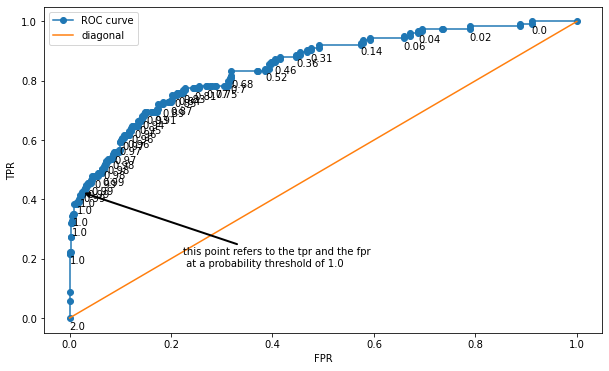

In [9]:
# vykreslenie ROC krivky s optimálnou hodnotou prahu
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 27
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [11]:
loaded_model = keras.models.load_model('../FrantisekUrban/callback_model/main_without_imggen.hdf5')
print("main_without_imggen.hdf5")
vysledky = loaded_model.evaluate(X_test, y_test)

y_pred = loaded_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.99] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_without_imggen.hdf5
38/38 [==============================] - 3s 75ms/step - loss: 1.0226 - accuracy: 0.6331
Confusion_matrix
[[1004   62]
 [  64   61]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.94      0.94      0.94      1066
    Positive       0.50      0.49      0.49       125

    accuracy                           0.89      1191
   macro avg       0.72      0.71      0.72      1191
weighted avg       0.89      0.89      0.89      1191

AUC: 0.8471969981238274


### Vyhodnotenie výsledkov procesu trénovania

In [8]:
drop1 = 0.25 
drop2 = 0.5 
dense = 1024
epochs = 20
batch_size = 40 

def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=[299, 299,1], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

#     model.summary()
    
    model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [9]:
#načítanie výtvorených váh
weights = glob.glob("../FrantisekUrban/callback_model/" + "*.h5")
weights[49:59]

['../FrantisekUrban/callback_model/main_without_imggen-02.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-04.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-06.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-08.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-10.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-12.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-14.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-16.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-18.h5',
 '../FrantisekUrban/callback_model/main_without_imggen-20.h5']

In [10]:
# vytvorenie dataframu pre uloženie výsledkov
header = ["Model", "Accuracy", "Loss", "AUC"]
dataframe = pd.DataFrame(columns = header)  
dataframe

,Model,Accuracy,Loss,AUC


In [12]:
# vyhodnotenie modelov
for weight in weights[54:59]:
    new_model = create_model()
    new_model.load_weights(weight)
    print(weight.split("/")[3])
    score = new_model.evaluate(X_test, y_test)
    
    y_pred = new_model.predict(X_test)
    y_int = np.zeros_like(y_pred)
    y_int[y_pred > 0.50] = 1
    y_testt = y_test.astype('float32')
    print("DONE")
    
    cm = confusion_matrix(y_testt, y_int)
    print('Confusion_matrix')
    print(cm)
    print('-------------------Classification_report-------------------')
    target_names = ['Negative', 'Positive']
    print(classification_report(y_testt, y_int, target_names=target_names))
    
    rocauc = roc_auc_score(y_test, y_pred)
    print('AUC: {}'.format(rocauc))
    print(" ")
    
    row = {'Model': weight.split("/")[3],
           'Accuracy': round(score[1],4),
           'Loss': round(score[0],4),
           'AUC':round(rocauc,4) ,
          }
    dataframe = dataframe.append(row, ignore_index=True)

main_without_imggen-12.h5
38/38 [==============================] - 3s 85ms/step - loss: 0.4237 - accuracy: 0.8732
DONE
Confusion_matrix
[[949 117]
 [ 34  91]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.89      0.93      1066
    Positive       0.44      0.73      0.55       125

    accuracy                           0.87      1191
   macro avg       0.70      0.81      0.74      1191
weighted avg       0.91      0.87      0.89      1191

AUC: 0.8942739212007504
 
main_without_imggen-14.h5
38/38 [==============================] - 3s 78ms/step - loss: 0.4349 - accuracy: 0.9102
DONE
Confusion_matrix
[[1066    0]
 [ 107   18]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      1066
    Positive       1.00      0.14      0.25       125

    accuracy                           0.

In [13]:
#zobrazenie dosiahnutých výsledkov
dataframe

,Model,Accuracy,Loss,AUC
0,main_without_imggen-02.h5,0.6667,0.8677,0.7122
1,main_without_imggen-04.h5,0.7842,0.5780,0.8209
2,main_without_imggen-06.h5,0.6297,1.0071,0.8433
3,main_without_imggen-08.h5,0.8060,0.4896,0.8825
4,main_without_imggen-10.h5,0.5542,1.5291,0.8965
5,main_without_imggen-12.h5,0.8732,0.4237,0.8943
6,main_without_imggen-14.h5,0.9102,0.4349,0.8520
7,main_without_imggen-16.h5,0.9127,0.3764,0.8798
8,main_without_imggen-18.h5,0.8992,0.3900,0.8969
9,main_without_imggen-20.h5,0.8799,0.4344,0.8805


In [14]:
dataframe.to_csv('../FrantisekUrban/experiment1.csv', index=False)

In [17]:
weights[57]

'../FrantisekUrban/callback_model/main_without_imggen-18.h5'

### Vyhodnotenie najlepšieho modelu

In [18]:
new_model = create_model()
new_model.load_weights(weights[57])
print(weights[57].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_without_imggen-18.h5
38/38 [==============================] - 3s 78ms/step - loss: 0.3900 - accuracy: 0.8992
Confusion_matrix
[[979  87]
 [ 33  92]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.92      0.94      1066
    Positive       0.51      0.74      0.61       125

    accuracy                           0.90      1191
   macro avg       0.74      0.83      0.77      1191
weighted avg       0.92      0.90      0.91      1191

AUC: 0.8968930581613508


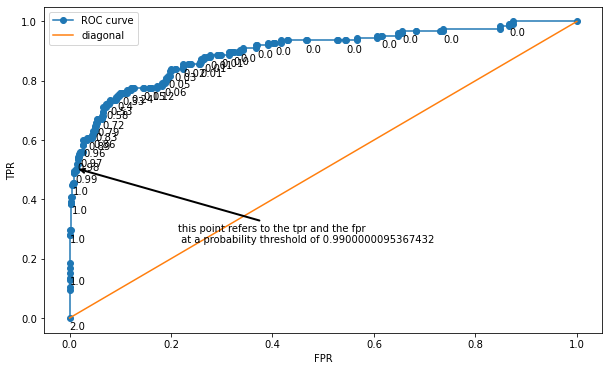

In [24]:
# vykreslenie ROC krivky s optimálnou hodnotou prahu
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 27
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("../FrantisekUrban/plots/e1plot-optROCcurve.png", bbox_inches='tight', dpi = 200)

In [20]:
new_model = create_model()
new_model.load_weights(weights[57])
print(weights[57].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.99] = 1
y_testt = y_test.astype('float32')

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(rocauc))

main_without_imggen-18.h5
38/38 [==============================] - 3s 81ms/step - loss: 0.3900 - accuracy: 0.8992
Confusion_matrix
[[1053   13]
 [  63   62]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97      1066
    Positive       0.83      0.50      0.62       125

    accuracy                           0.94      1191
   macro avg       0.89      0.74      0.79      1191
weighted avg       0.93      0.94      0.93      1191

AUC: 0.8968930581613508


In [4]:
#načítanie uloženého dataframu vysledkov
dataframe = pd.read_csv('../FrantisekUrban/experiment1.csv')
dataframe

,Model,Accuracy,Loss,AUC
0,main_without_imggen-02.h5,0.6667,0.8677,0.7122
1,main_without_imggen-04.h5,0.7842,0.5780,0.8209
2,main_without_imggen-06.h5,0.6297,1.0071,0.8433
3,main_without_imggen-08.h5,0.8060,0.4896,0.8825
4,main_without_imggen-10.h5,0.5542,1.5291,0.8965
5,main_without_imggen-12.h5,0.8732,0.4237,0.8943
6,main_without_imggen-14.h5,0.9102,0.4349,0.8520
7,main_without_imggen-16.h5,0.9127,0.3764,0.8798
8,main_without_imggen-18.h5,0.8992,0.3900,0.8969
9,main_without_imggen-20.h5,0.8799,0.4344,0.8805


### Grafická reprezentácia výsledkov

In [5]:
# načítanie AUC a Úspešnosti
acc = dataframe["Accuracy"]
auc = dataframe["AUC"]

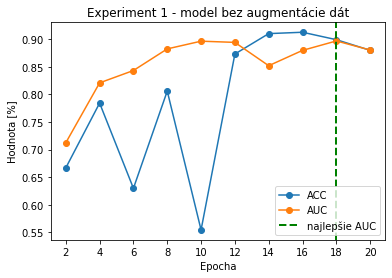

Najlepší vysledok je na epoche: 18


In [6]:
# vykreslenie grafu
epochs = [2,4,6,8,10,12,14,16,18,20]

plt.plot(epochs, acc, label = 'ACC', linestyle='-', marker='o')
plt.plot(epochs, auc, label = 'AUC', linestyle='-', marker='o')

plt.axvline(x = 18, ls='--', lw=2, c='green', label='najlepšie AUC')
# naming the x axis
plt.xlabel('Epocha')
plt.xticks([2,4,6,8,10,12,14,16,18,20])
# naming the y axis
plt.ylabel('Hodnota [%]')
plt.title('Experiment 1 - model bez augmentácie dát')
plt.legend(loc ="lower right")
plt.savefig("../FrantisekUrban/plots/e1plot-vysledok-epoch.png", bbox_inches='tight', dpi = 200)
plt.show()

print("Najlepší vysledok je na epoche: {}".format(18))